<a href="https://colab.research.google.com/github/SewoongPark/SeSac_study_repo/blob/main/study_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TIL**
* bias = x가 0일 때 모델이 예측하는 y값
   > * bias는 모델이 입력 데이터의 특정 편향이나 상수를 고려할 수 있게 함
   > * $y = wx + b$
   > * 인공신경망에서는 각 층마다 bias가 존재함, 이때 bias는 각 뉴런에 추가되어 해당 뉴런이 얼마나 쉽게 활성화되는지를 결정하는 요소 중 하나
* ### **활성화 함수(activation function)**
  > * 딥러닝 네트워크에서 노드에 입력된 값들을 비선형 함수에 통과시킨 후 다음 레이어로 전달하는데, 이때 사용하는 함수를 활성화 함수라고 한다.
  > * 선형 함수가 아니라 비선형 함수를 사용하는 이유는 딥러닝 모델의 레이어 층을 깊게 가져갈 수 있기 때문이다
  
  * 종류 비교

  * <img src = "https://mblogthumb-phinf.pstatic.net/MjAyMDAyMjVfMTQ3/MDAxNTgyNjA5NDY3MTY3.228bUv_5mrol1w7X0NiFMD1UNru9zyf3yIJGcON-An0g.3Kzynlja9y_F9yTfANl937elQAK1pTGoJ_al7Om7TYsg.PNG.handuelly/image.png?type=w800">

  * 인공지능기의 암흑기는 적절한 활성화 함수를 찾지 못함으로써 발생
  * 적절한 활성화 함수를 찾게 된 이후 암흑기 종결

  * **ReLU**
  > * ReLU(Rectified Linear Unit, 경사함수)는 가장 많이 사용되는 활성화 함수 중 하나이다.
  > * Sigmoid와 tanh가 갖는 Gradient Vanishing 문제를 해결하기 위한 함수이다.
  * ReLU의 정의
  * $f(x) = max(0, x)$
    * <img src = "https://mblogthumb-phinf.pstatic.net/MjAyMDAyMjVfOTIg/MDAxNTgyNjA4MzI2NDA5.e0VyX0yrhE5gtfPjni7IxF5kpArCeByreQsdOMB0240g.CWwTi57bPtAK6C7eLmRn1ED2RE8Lm_C6sVIwMGJS1Akg.PNG.handuelly/image.png?type=w800" style="width: 50%;">

    * x가 0보다 크면 기울기가 1인 직선, 0보다 작으면 함수 값이 0이 된다. 이는 0보다 작은 값들에서 뉴런이 죽을 수 있는 단점을 야기한다.
    * 또한 sigmoid, tanh 함수보다 학습이 빠르고, 연산 비용이 적고, 구현이 매우 간단하다는 특징이 있다.

---

  * **ReLU 함수 예시**
    * x값이 1보다 크면 그대로 유지, 0보다 작으면 0으로 변경하는 것을 확인할 수 있다.

    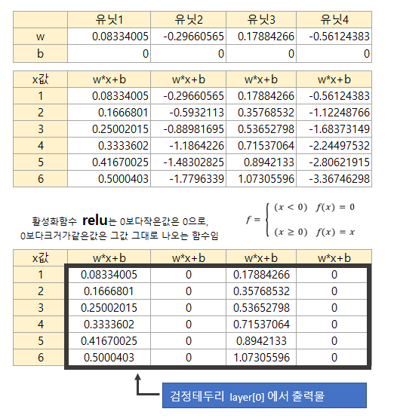

    

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([10, 98, 8, 2, 3, 4])

tf.random.set_seed(1234)

In [14]:
input_layer = tf.keras.layers.InputLayer(input_shape = (1,))
hidden_layer1 = tf.keras.layers.Dense(units=4, activation = "relu")
hidden_layer2 = tf.keras.layers.Dense(units=2, activation = "relu")
output_layer = tf.keras.layers.Dense(units = 1)

model = keras.Sequential([
    input_layer,
    hidden_layer1,
    hidden_layer2,
    # hidden_layer1이나 2를 다시 사용해도 됨(pytorch의 구조)
    output_layer,

])

### 모델 컴파일

In [15]:
model.compile(optimizer = "adam",
              loss = "mse",
              metrics = ["accuracy"]
)
print(model.fit(x, y))
print(model.predict(x))
print(model.evaluate(x, y))

1/1 [==============================] - 0s 60ms/step
[[0.7088854]
 [1.4151396]
 [2.1213934]
 [2.8276477]
 [3.5339017]
 [4.2401557]]
1/1 [==============================] - 0s 143ms/step - loss: 1575.0909 - accuracy: 0.0000e+00
[1575.0909423828125, 0.0]


In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 8         
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### weight값은 정규분포를 따른다
* start값이 달라서

In [30]:
modelValue = model.weights # 실행할때마다 weight값은 달라진다
# 모델의 weight는 x_data와의 내적 연산을 위해 행렬 구조를 맞춰줘야 한다
# ex) x_input은 (6 * 1) ->> weight는 unit이 4이므로 (1 * 4)의 구조로 맞춰짐
modelValue[0]

<tf.Variable 'dense_3/kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[-0.58537453, -0.96768856,  0.3894623 ,  1.0611197 ]],
      dtype=float32)>

### **input데이터의 구조에 따라 달라지는 layer의 내적 연산**
* layer에서의 연산 결과 output은 다음 layer의 input으로 사용,
* input 데이터의 구조에 따라 weight의 구조도 변경됨(내적 연산을 위해)

---

* **1차원 입력 데이터:**

> * 이 경우 내적 연산은 입력 벡터와 가중치 벡터 간의 행렬 곱(matrix multiplication)으로 이루어집니다.
* 가중치는 입력 벡터의 길이와 같은 1차원 벡터로 구성됩니다.

* **2차원 이미지 데이터:**

> * 이미지는 보통 2차원 구조로 표현됩니다. 각 픽셀은 이미지의 행과 열에 따라 위치가 지정됩니다.
* 이 경우 내적 연산은 이미지와 가중치 사이의 합성곱 연산(convolution)으로 이루어집니다.
* 가중치는 일반적으로 필터(filter)로 표현되며, 입력 이미지와 필터 간의 합성곱을 통해 출력 값이 생성됩니다.

* **3차원 데이터:**

> * 이 경우 내적 연산은 입력과 가중치 텐서 간의 텐서 곱(tensor multiplication)으로 이루어집니다.
* 가중치는 입력 텐서와 동일한 차원의 텐서로 구성됩니다.

In [40]:
# 0번 레이어 = Dense(units = 4)
  # x_input의 길이(6)와 unit의 개수(4)에 의해 0번 레이어의 출력물이 정해짐
  # input: (6, 1)
  # output: 6 * 4 -> 다음 레이어의 input 데이터의 행렬 구조
# 1번 레이어 = Dense(units = 2)
  # input: (6 * 4) -> 4열을 맞춰줘야 함 -> 4행(x변수 4개 각각의 weight) 2열(w값) -> input 데이터와 내적 연산
  # weight: 4 * 2
  # output: 6 * 2
# 2번 레이어 = Dense(units = 1)
  # input: 6 * 2
  # weight: 2 * 1
  # 출력물: 6 * 1

for i in range(3):
  intermediate_layer_model = tf.keras.Model(inputs = model.input, outputs = model.layers[i].output)
  intermediate_output = intermediate_layer_model(x)

  print(f"outputs of hidden layer_{i}")
  print(intermediate_output)
  print("-"* 20)

outputs of hidden layer_0
tf.Tensor(
[[0.         0.         0.39046228 1.0621197 ]
 [0.         0.         0.7799246  2.1232393 ]
 [0.         0.         1.169387   3.184359  ]
 [0.         0.         1.5588492  4.2454786 ]
 [0.         0.         1.9483114  5.306598  ]
 [0.         0.         2.3377738  6.367718  ]], shape=(6, 4), dtype=float32)
--------------------
outputs of hidden layer_1
tf.Tensor(
[[0.8209072 0.       ]
 [1.6399226 0.       ]
 [2.4589381 0.       ]
 [3.2779536 0.       ]
 [4.096969  0.       ]
 [4.9159846 0.       ]], shape=(6, 2), dtype=float32)
--------------------
outputs of hidden layer_2
tf.Tensor(
[[0.7088854]
 [1.4151396]
 [2.1213934]
 [2.8276477]
 [3.5339017]
 [4.2401557]], shape=(6, 1), dtype=float32)
--------------------


In [32]:
modelValue[2:5] # 두번쨰 layer의 weight 구조는 4 * 2(input의 열이 4개 이므로 4행, unit의 개수가 2개이므로 2열)

[<tf.Variable 'dense_4/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[-0.6345396 ,  0.02001047],
        [-0.25561   ,  0.7517214 ],
        [ 0.18938118, -0.21074367],
        [ 0.7023323 , -0.2933967 ]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(2,) dtype=float32, numpy=array([0.00099999, 0.        ], dtype=float32)>,
 <tf.Variable 'dense_5/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[ 0.86232084],
        [-0.01587856]], dtype=float32)>]

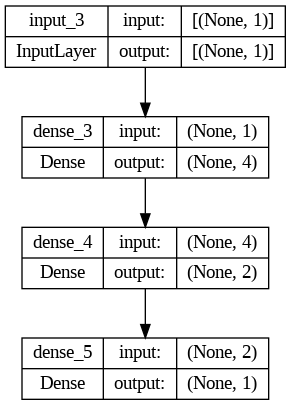

In [33]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file = "model.png", show_shapes = True)


**연습: 원핫 인코딩**

In [47]:
import pandas as pd
roomCnt = [1, 2, 1, 1, 2, 1, 3, 4]
year=[2001,1997,1998,2020,1994,1999,2000,2010] #건축년도
재건축여부등급=['A','B','A','A','C','A','A','B']

df = pd.DataFrame({"방갯수": roomCnt, "건축년도":year, "재건축여부등급": 재건축여부등급 })
df['건축년도'] = df['건축년도'] / 2000
df['건축년도'] = df['건축년도'].astype('int32')
x = df[['방갯수', '건축년도']].values
y = df['재건축여부등급'].values
df

,방갯수,건축년도,재건축여부등급
0,1,1,A
1,2,0,B
2,1,0,A
3,1,1,A
4,2,0,C
5,1,0,A
6,3,1,A
7,4,1,B


In [51]:
from sklearn.preprocessing import LabelEncoder
e = LabelEncoder()
e.fit(y)
ydata = e.transform(y)
ydata

array([0, 1, 0, 0, 2, 0, 0, 1])

In [53]:
import tensorflow as tf
y_encoded = tf.keras.utils.to_categorical(ydata)
y_encoded

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)